

<center>
    <h1 style="color:red;text-align:center;">
        Best Model Selection
    </h1>
    <h3>Deep Learning Enthusiast, It for you</h3>
</center>

Hi Deep learning enthusiast,  You must be work with model.In transfer learning method
everyone try make own model using pretrain model (EfficientB7, VGG-19, inceptionv3, resnet, etc)

<h4 style='color: red' > But which model may be best for you? </h4>
Criteria for selecting models
In general, there are two competing criteria while doing any machine learning task in the industry:

1.Accuracy of the model: Higher Better

2.Speed of Model Training and Predictions: Faster Better


#### Selecting best model step by step

<h3 style='color: green' >STEP 1 : import packages</h3>

The first step is to import the necessary packages.

In [ ]:
# Imports
import tensorflow as tf

import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm

# Set batch size for training and validation
batch_size = 32

<h3 style='color: green' >STEP 2 : list all pretrain model</h3>

Automatically get a list of all available pre-trained models from Keras by listing all the functions inside `tf.keras.applications`. Since each model is instantiated by calling a function from `tf.keras.applications`, when we list all the functions within this module using `inspect.isfunction`, we get a list of all the models. As of this writing, in [Tensorflow 2.2]

In [ ]:

# List all available models
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

In [ ]:
model_dictionary

{'DenseNet121': <function tensorflow.python.keras.applications.densenet.DenseNet121>,
 'DenseNet169': <function tensorflow.python.keras.applications.densenet.DenseNet169>,
 'DenseNet201': <function tensorflow.python.keras.applications.densenet.DenseNet201>,
 'EfficientNetB0': <function tensorflow.python.keras.applications.efficientnet.EfficientNetB0>,
 'EfficientNetB1': <function tensorflow.python.keras.applications.efficientnet.EfficientNetB1>,
 'EfficientNetB2': <function tensorflow.python.keras.applications.efficientnet.EfficientNetB2>,
 'EfficientNetB3': <function tensorflow.python.keras.applications.efficientnet.EfficientNetB3>,
 'EfficientNetB4': <function tensorflow.python.keras.applications.efficientnet.EfficientNetB4>,
 'EfficientNetB5': <function tensorflow.python.keras.applications.efficientnet.EfficientNetB5>,
 'EfficientNetB6': <function tensorflow.python.keras.applications.efficientnet.EfficientNetB6>,
 'EfficientNetB7': <function tensorflow.python.keras.applications.effi

<h3 style='color: green' >STEP 3 : Download dataset</h3>

Download dataset to run the experiment. you can use tensorflow default datasets or you can use your custom dataset.

Here used tensorflow dataset -----------horses_or_humans
So its a binary classification problem, but you can use multi classes dataset , just change the name 'horses_or_humans' like as 'cats_and_dogs'.(70+ tensorflow datasets , you can choose anyone or make your own dataset)

In [ ]:
!pip install tensorflow_datasets
import tensorflow_datasets as tfds

In [ ]:
# Download the training and validation data
(train, validation), metadata = tfds.load('horses_or_humans', split=['train[:70%]', 'train[70%:]'],
                                          with_info=True, as_supervised=True)

# Number of training examples and labels
num_train = len(list(train))
num_validation = len(list(validation))
num_classes = len(metadata.features['label'].names)
num_iterations = int(num_train/batch_size)

# Print important info
print(f'Num train images: {num_train} \
        \nNum validation images: {num_validation} \
        \nNum classes: {num_classes} \
        \nNum iterations per epoch: {num_iterations}')

Shuffling and writing examples to /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteXOXL45/horses_or_humans-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteXOXL45/horses_or_humans-test.tfrecord


Dataset horses_or_humans downloaded and prepared to /root/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.
Num train images: 719         
Num validation images: 308         
Num classes: 2         
Num iterations per epoch: 22


<h3 style='color:green'>STEP-4 : Preprocessing data </h3>

Preprocess the input images. Some pre-trained models require images to be of size (224,224,3) while some require (331,331,3). We use this step to prepare both sizes of images and normalize them by dividing each pixel by 255. We also one-hot encode the labels so that we can use `categorical_crossentropy` loss during training.

In [ ]:
def normalize_img(image, label, img_size):
    # Resize image to the desired img_size and normalize it
    # One hot encode the label
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.
    label = tf.one_hot(label, depth=num_classes)
    return image, label

def preprocess_data(train, validation, batch_size, img_size):
    # Apply the normalize_img function on all train and validation data and create batches
    train_processed = train.map(lambda image, label: normalize_img(image, label, img_size))
    train_processed = train_processed.batch(batch_size).repeat()

    validation_processed = validation.map(lambda image, label: normalize_img(image, label, img_size))
    validation_processed = validation_processed.batch(batch_size)

    return train_processed, validation_processed

# Run preprocessing
train_processed_224, validation_processed_224 = preprocess_data(train, validation, batch_size, img_size=[224,224])
train_processed_331, validation_processed_331 = preprocess_data(train, validation, batch_size, img_size=[331,331])

<h3 style='color:green'>STEP-5 : Run each model </h3>

Loop over each model by downloading the pre-trained model without the output layers and freeze the weights. We then construct an empty `Sequential` model and first add the pre-trained model to it. We then add a single output Dense layer with `softmax` activation and compile it with `categorical_crossentropy` loss. Finally, we train the model by calling `model.fit` for `3 epochs`. We log the number of parameters (size of the model) and each model's final accuracy into a dictionary to visualize the results. If you get the following error during the model download `AttributeError: 'str' object has no attribute 'decode'`, install a lower version of `h5py` [[source]](https://github.com/tensorflow/tensorflow/issues/44467)

```
pip uninstall h5py

In [ ]:
!pip install h5py

In [ ]:
# Loop over each model available in Keras
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}
for model_name, model in tqdm(model_dictionary.items()):
    # Special handling for "NASNetLarge" since it requires input images with size (331,331)
    if 'NASNetLarge' in model_name:
        input_shape=(331,331,3)
        train_processed = train_processed_331
        validation_processed = validation_processed_331
    else:
        input_shape=(224,224,3)
        train_processed = train_processed_224
        validation_processed = validation_processed_224

    # load the pre-trained model with global average pooling as the last layer and freeze the model weights
    pre_trained_model = model(include_top=False, pooling='avg', input_shape=input_shape)
    pre_trained_model.trainable = False

    # custom modifications on top of pre-trained model
    clf_model = tf.keras.models.Sequential()
    clf_model.add(pre_trained_model)
    clf_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    clf_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    history = clf_model.fit(train_processed, epochs=3, validation_data=validation_processed,
                            steps_per_epoch=num_iterations)

    # Calculate all relevant metrics
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
    model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1/3
22/22 [==============================] - 107s 5s/step - loss: 0.3198 - accuracy: 0.8622 - val_loss: 0.1030 - val_accuracy: 0.9935
Epoch 2/3
22/22 [==============================] - 99s 5s/step - loss: 0.0562 - accuracy: 0.9985 - val_loss: 0.0381 - val_accuracy: 0.9935
Epoch 3/3
22/22 [==============================] - 99s 5s/step - loss: 0.0229 - accuracy: 0.9985 - val_loss: 0.0160 - val_accuracy: 1.0000


  4%|▎         | 1/28 [05:30<2:28:37, 330.28s/it]

51879936/51877672 [==============================] - 1s 0us/step
Epoch 1/3
22/22 [==============================] - 129s 6s/step - loss: 0.2263 - accuracy: 0.9261 - val_loss: 0.0652 - val_accuracy: 0.9968
Epoch 2/3
22/22 [==============================] - 118s 6s/step - loss: 0.0357 - accuracy: 0.9971 - val_loss: 0.0237 - val_accuracy: 0.9968
Epoch 3/3
22/22 [==============================] - 117s 5s/step - loss: 0.0127 - accuracy: 0.9985 - val_loss: 0.0109 - val_accuracy: 0.9968


  7%|▋         | 2/28 [12:05<2:31:32, 349.71s/it]

74842112/74836368 [==============================] - 1s 0us/step
Epoch 1/3
22/22 [==============================] - 164s 7s/step - loss: 0.1256 - accuracy: 0.9787 - val_loss: 0.0358 - val_accuracy: 1.0000
Epoch 2/3
22/22 [==============================] - 151s 7s/step - loss: 0.0192 - accuracy: 0.9985 - val_loss: 0.0122 - val_accuracy: 1.0000
Epoch 3/3
22/22 [==============================] - 151s 7s/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 1.0000


 11%|█         | 3/28 [20:42<2:46:39, 399.99s/it]

16711680/16705208 [==============================] - 0s 0us/step
Epoch 1/3
22/22 [==============================] - 39s 2s/step - loss: 0.6995 - accuracy: 0.5028 - val_loss: 0.6926 - val_accuracy: 0.5162
Epoch 2/3
22/22 [==============================] - 32s 2s/step - loss: 0.6959 - accuracy: 0.5211 - val_loss: 0.6956 - val_accuracy: 0.4838
Epoch 3/3
22/22 [==============================] - 32s 1s/step - loss: 0.6966 - accuracy: 0.5095 - val_loss: 0.6934 - val_accuracy: 0.4838


 14%|█▍        | 4/28 [23:11<2:09:52, 324.71s/it]

27025408/27018416 [==============================] - 1s 0us/step
Epoch 1/3
22/22 [==============================] - 54s 2s/step - loss: 0.7047 - accuracy: 0.4972 - val_loss: 0.6943 - val_accuracy: 0.4838
Epoch 2/3
22/22 [==============================] - 45s 2s/step - loss: 0.6983 - accuracy: 0.4920 - val_loss: 0.6986 - val_accuracy: 0.4838
Epoch 3/3
22/22 [==============================] - 45s 2s/step - loss: 0.7004 - accuracy: 0.4993 - val_loss: 0.6931 - val_accuracy: 0.5162


 18%|█▊        | 5/28 [25:38<1:44:04, 271.49s/it]

31793152/31790344 [==============================] - 0s 0us/step
Epoch 1/3
22/22 [==============================] - 57s 2s/step - loss: 0.7033 - accuracy: 0.5071 - val_loss: 0.6926 - val_accuracy: 0.5162
Epoch 2/3
22/22 [==============================] - 48s 2s/step - loss: 0.7011 - accuracy: 0.4993 - val_loss: 0.6992 - val_accuracy: 0.4838
Epoch 3/3
22/22 [==============================] - 48s 2s/step - loss: 0.6956 - accuracy: 0.5269 - val_loss: 0.6958 - val_accuracy: 0.5162


 21%|██▏       | 6/28 [29:11<1:33:05, 253.86s/it]

43941888/43941136 [==============================] - 1s 0us/step
Epoch 1/3
22/22 [==============================] - 78s 3s/step - loss: 0.7092 - accuracy: 0.5241 - val_loss: 0.6939 - val_accuracy: 0.5162
Epoch 2/3
22/22 [==============================] - 67s 3s/step - loss: 0.7026 - accuracy: 0.5095 - val_loss: 0.7121 - val_accuracy: 0.4838
Epoch 3/3
22/22 [==============================] - 66s 3s/step - loss: 0.7042 - accuracy: 0.5240 - val_loss: 0.6983 - val_accuracy: 0.5162


 25%|██▌       | 7/28 [33:46<1:31:03, 260.18s/it]

71688192/71686520 [==============================] - 1s 0us/step
Epoch 1/3
22/22 [==============================] - 108s 4s/step - loss: 0.7116 - accuracy: 0.5227 - val_loss: 0.6938 - val_accuracy: 0.5162
Epoch 2/3
22/22 [==============================] - 94s 4s/step - loss: 0.7012 - accuracy: 0.5226 - val_loss: 0.7158 - val_accuracy: 0.4838
Epoch 3/3
22/22 [==============================] - 93s 4s/step - loss: 0.7024 - accuracy: 0.5226 - val_loss: 0.6975 - val_accuracy: 0.5162


 29%|██▊       | 8/28 [38:47<1:30:47, 272.36s/it]

115269632/115263384 [==============================] - 3s 0us/step
Epoch 1/3
22/22 [==============================] - 152s 6s/step - loss: 0.7236 - accuracy: 0.4943 - val_loss: 0.6949 - val_accuracy: 0.5162
Epoch 2/3
22/22 [==============================] - 133s 6s/step - loss: 0.7066 - accuracy: 0.5284 - val_loss: 0.7061 - val_accuracy: 0.4838
Epoch 3/3
22/22 [==============================] - 136s 6s/step - loss: 0.7081 - accuracy: 0.5095 - val_loss: 0.7042 - val_accuracy: 0.5162


 32%|███▏      | 9/28 [46:31<1:44:29, 329.98s/it]

165240832/165234480 [==============================] - 3s 0us/step
Epoch 1/3
22/22 [==============================] - 201s 9s/step - loss: 0.7283 - accuracy: 0.5256 - val_loss: 0.6971 - val_accuracy: 0.5162
Epoch 2/3
22/22 [==============================] - 180s 8s/step - loss: 0.7142 - accuracy: 0.5211 - val_loss: 0.7580 - val_accuracy: 0.4838
Epoch 3/3
22/22 [==============================] - 180s 8s/step - loss: 0.7138 - accuracy: 0.5109 - val_loss: 0.6933 - val_accuracy: 0.5162


 36%|███▌      | 10/28 [56:18<2:02:06, 407.05s/it]

258080768/258076736 [==============================] - 6s 0us/step
Epoch 1/3
22/22 [==============================] - 300s 13s/step - loss: 0.7357 - accuracy: 0.5284 - val_loss: 0.6996 - val_accuracy: 0.5162
Epoch 2/3
22/22 [==============================] - 272s 13s/step - loss: 0.7120 - accuracy: 0.5124 - val_loss: 0.7260 - val_accuracy: 0.4838
Epoch 3/3
22/22 [==============================] - 273s 13s/step - loss: 0.7166 - accuracy: 0.5255 - val_loss: 0.6926 - val_accuracy: 0.5162


 39%|███▉      | 11/28 [1:11:16<2:37:00, 554.14s/it]

219062272/219055592 [==============================] - 3s 0us/step
Epoch 1/3
22/22 [==============================] - 189s 8s/step - loss: 0.2050 - accuracy: 0.9261 - val_loss: 0.0399 - val_accuracy: 1.0000
Epoch 2/3
22/22 [==============================] - 172s 8s/step - loss: 0.0214 - accuracy: 0.9985 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 3/3
22/22 [==============================] - 172s 8s/step - loss: 0.0086 - accuracy: 0.9985 - val_loss: 0.0044 - val_accuracy: 1.0000


 43%|████▎     | 12/28 [1:20:58<2:30:01, 562.62s/it]

87916544/87910968 [==============================] - 2s 0us/step
Epoch 1/3
22/22 [==============================] - 83s 4s/step - loss: 0.3393 - accuracy: 0.9020 - val_loss: 0.0561 - val_accuracy: 0.9968
Epoch 2/3
22/22 [==============================] - 77s 4s/step - loss: 0.0365 - accuracy: 0.9942 - val_loss: 0.0164 - val_accuracy: 0.9968
Epoch 3/3
22/22 [==============================] - 77s 4s/step - loss: 0.0176 - accuracy: 0.9985 - val_loss: 0.0061 - val_accuracy: 1.0000


 46%|████▋     | 13/28 [1:24:59<1:56:32, 466.17s/it]

17227776/17225924 [==============================] - 1s 0us/step
Epoch 1/3
22/22 [==============================] - 28s 1s/step - loss: 0.2243 - accuracy: 0.9119 - val_loss: 0.0710 - val_accuracy: 0.9903
Epoch 2/3
22/22 [==============================] - 26s 1s/step - loss: 0.0335 - accuracy: 0.9971 - val_loss: 0.0321 - val_accuracy: 0.9935
Epoch 3/3
22/22 [==============================] - 26s 1s/step - loss: 0.0119 - accuracy: 0.9985 - val_loss: 0.0152 - val_accuracy: 0.9935


 50%|█████     | 14/28 [1:26:25<1:22:07, 351.98s/it]

9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/3
22/22 [==============================] - 25s 1s/step - loss: 0.1613 - accuracy: 0.9460 - val_loss: 0.0349 - val_accuracy: 1.0000
Epoch 2/3
22/22 [==============================] - 22s 1s/step - loss: 0.0262 - accuracy: 0.9971 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 3/3
22/22 [==============================] - 22s 995ms/step - loss: 0.0130 - accuracy: 0.9985 - val_loss: 0.0059 - val_accuracy: 1.0000


 54%|█████▎    | 15/28 [1:27:50<58:57, 272.08s/it]  

17612800/17605208 [==============================] - 0s 0us/step
Epoch 1/3
22/22 [==============================] - 30s 1s/step - loss: 0.7227 - accuracy: 0.5057 - val_loss: 0.6894 - val_accuracy: 0.5162
Epoch 2/3
22/22 [==============================] - 22s 1s/step - loss: 0.6915 - accuracy: 0.5400 - val_loss: 0.7016 - val_accuracy: 0.4838
Epoch 3/3
22/22 [==============================] - 22s 1s/step - loss: 0.6790 - accuracy: 0.5575 - val_loss: 0.6604 - val_accuracy: 0.5455


 57%|█████▋    | 16/28 [1:29:20<43:30, 217.52s/it]

6701056/6698480 [==============================] - 0s 0us/step
Epoch 1/3
22/22 [==============================] - 14s 515ms/step - loss: 0.7108 - accuracy: 0.5142 - val_loss: 0.6907 - val_accuracy: 0.5162
Epoch 2/3
22/22 [==============================] - 10s 478ms/step - loss: 0.6957 - accuracy: 0.5298 - val_loss: 0.7005 - val_accuracy: 0.4838
Epoch 3/3
22/22 [==============================] - 10s 470ms/step - loss: 0.6903 - accuracy: 0.5400 - val_loss: 0.6845 - val_accuracy: 0.5195


 61%|██████    | 17/28 [1:30:06<30:25, 165.95s/it]

343613440/343610240 [==============================] - 5s 0us/step
Epoch 1/3
22/22 [==============================] - 799s 36s/step - loss: 0.0839 - accuracy: 0.9787 - val_loss: 0.0175 - val_accuracy: 1.0000
Epoch 2/3
22/22 [==============================] - 760s 36s/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 3/3
22/22 [==============================] - 767s 35s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000


 64%|██████▍   | 18/28 [2:10:03<2:19:13, 835.37s/it]

19996672/19993432 [==============================] - 1s 0us/step
Epoch 1/3
22/22 [==============================] - 69s 3s/step - loss: 0.2342 - accuracy: 0.9361 - val_loss: 0.0741 - val_accuracy: 0.9968
Epoch 2/3
22/22 [==============================] - 52s 2s/step - loss: 0.0401 - accuracy: 0.9971 - val_loss: 0.0308 - val_accuracy: 0.9968
Epoch 3/3
22/22 [==============================] - 53s 2s/step - loss: 0.0180 - accuracy: 0.9985 - val_loss: 0.0158 - val_accuracy: 0.9968


 68%|██████▊   | 19/28 [2:13:06<1:35:55, 639.50s/it]

171450368/171446536 [==============================] - 3s 0us/step
Epoch 1/3
22/22 [==============================] - 232s 10s/step - loss: 0.6905 - accuracy: 0.5412 - val_loss: 0.6624 - val_accuracy: 0.5779
Epoch 2/3
22/22 [==============================] - 215s 10s/step - loss: 0.6610 - accuracy: 0.6317 - val_loss: 0.6457 - val_accuracy: 0.6104
Epoch 3/3
22/22 [==============================] - 216s 10s/step - loss: 0.6388 - accuracy: 0.6681 - val_loss: 0.6182 - val_accuracy: 0.6364


 71%|███████▏  | 20/28 [2:24:43<1:27:33, 656.70s/it]

171319296/171317808 [==============================] - 3s 0us/step
Epoch 1/3
22/22 [==============================] - 204s 9s/step - loss: 0.1226 - accuracy: 0.9588 - val_loss: 0.0131 - val_accuracy: 1.0000
Epoch 2/3
22/22 [==============================] - 194s 9s/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 3/3
22/22 [==============================] - 194s 9s/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000


 75%|███████▌  | 21/28 [2:35:18<1:15:52, 650.38s/it]

234700800/234698864 [==============================] - 5s 0us/step
Epoch 1/3
22/22 [==============================] - 326s 15s/step - loss: 0.7107 - accuracy: 0.4844 - val_loss: 0.6823 - val_accuracy: 0.5584
Epoch 2/3
22/22 [==============================] - 308s 14s/step - loss: 0.6866 - accuracy: 0.5502 - val_loss: 0.6757 - val_accuracy: 0.5260
Epoch 3/3
22/22 [==============================] - 309s 14s/step - loss: 0.6682 - accuracy: 0.5953 - val_loss: 0.6568 - val_accuracy: 0.5649


 79%|███████▊  | 22/28 [2:52:02<1:15:38, 756.35s/it]

234553344/234545216 [==============================] - 6s 0us/step
Epoch 1/3
22/22 [==============================] - 333s 15s/step - loss: 0.1081 - accuracy: 0.9574 - val_loss: 0.0167 - val_accuracy: 1.0000
Epoch 2/3
22/22 [==============================] - 311s 15s/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 3/3
22/22 [==============================] - 317s 15s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000


 82%|████████▏ | 23/28 [3:08:44<1:09:10, 830.08s/it]

94773248/94765736 [==============================] - 3s 0us/step
Epoch 1/3
22/22 [==============================] - 122s 5s/step - loss: 0.7045 - accuracy: 0.5298 - val_loss: 0.6679 - val_accuracy: 0.5584
Epoch 2/3
22/22 [==============================] - 115s 5s/step - loss: 0.6644 - accuracy: 0.6114 - val_loss: 0.6516 - val_accuracy: 0.5227
Epoch 3/3
22/22 [==============================] - 117s 5s/step - loss: 0.6396 - accuracy: 0.6405 - val_loss: 0.6172 - val_accuracy: 0.6299


 86%|████████▌ | 24/28 [3:15:15<46:32, 698.21s/it]  

94674944/94668760 [==============================] - 2s 0us/step
Epoch 1/3
22/22 [==============================] - 109s 5s/step - loss: 0.0604 - accuracy: 0.9830 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 2/3
22/22 [==============================] - 104s 5s/step - loss: 0.0078 - accuracy: 0.9985 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 3/3
22/22 [==============================] - 104s 5s/step - loss: 0.0030 - accuracy: 0.9985 - val_loss: 0.0015 - val_accuracy: 1.0000


 89%|████████▉ | 25/28 [3:20:43<29:22, 587.36s/it]

58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/3
22/22 [==============================] - 380s 17s/step - loss: 0.6347 - accuracy: 0.7358 - val_loss: 0.5627 - val_accuracy: 0.9026
Epoch 2/3
22/22 [==============================] - 374s 18s/step - loss: 0.5330 - accuracy: 0.8952 - val_loss: 0.4828 - val_accuracy: 0.9351
Epoch 3/3
22/22 [==============================] - 373s 17s/step - loss: 0.4609 - accuracy: 0.9185 - val_loss: 0.4129 - val_accuracy: 0.9253


 93%|█████████▎| 26/28 [3:40:07<25:20, 760.32s/it]

80142336/80134624 [==============================] - 2s 0us/step
Epoch 1/3
22/22 [==============================] - 483s 22s/step - loss: 0.6230 - accuracy: 0.7074 - val_loss: 0.5477 - val_accuracy: 0.8506
Epoch 2/3
22/22 [==============================] - 470s 22s/step - loss: 0.5391 - accuracy: 0.8282 - val_loss: 0.4820 - val_accuracy: 0.8961
Epoch 3/3
22/22 [==============================] - 471s 22s/step - loss: 0.4753 - accuracy: 0.8792 - val_loss: 0.4212 - val_accuracy: 0.8961


 96%|█████████▋| 27/28 [4:04:32<16:11, 971.72s/it]

83689472/83683744 [==============================] - 2s 0us/step
Epoch 1/3
22/22 [==============================] - 135s 6s/step - loss: 0.1090 - accuracy: 0.9759 - val_loss: 0.0271 - val_accuracy: 1.0000
Epoch 2/3
22/22 [==============================] - 129s 6s/step - loss: 0.0186 - accuracy: 0.9985 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 3/3
22/22 [==============================] - 128s 6s/step - loss: 0.0093 - accuracy: 0.9985 - val_loss: 0.0046 - val_accuracy: 1.0000


100%|██████████| 28/28 [4:12:02<00:00, 540.08s/it]


<h3 style= 'color: green'>Visualize the results</h3>

Validation result with tensorflow pretrained model name

In [ ]:
# Convert Results to DataFrame for easy viewing
benchmark_df = pd.DataFrame(model_benchmarks)
benchmark_df.sort_values('num_model_params', inplace=True) # sort in ascending order of num_model_params column
benchmark_df.to_csv('benchmark_df.csv', index=False) # write results to csv file
benchmark_df

,model_name,num_model_params,validation_accuracy
16,MobileNetV3Small,1529968,0.519481
14,MobileNetV2,2257984,1.000000
13,MobileNet,3228864,0.993506
3,EfficientNetB0,4049571,0.483766
15,MobileNetV3Large,4226432,0.545455
18,NASNetMobile,4269716,0.996753
4,EfficientNetB1,6575239,0.516234
0,DenseNet121,7037504,1.000000
5,EfficientNetB2,7768569,0.516234
6,EfficientNetB3,10783535,0.516234


<h3 style= 'color: green'>Graphical Visualization</h3>

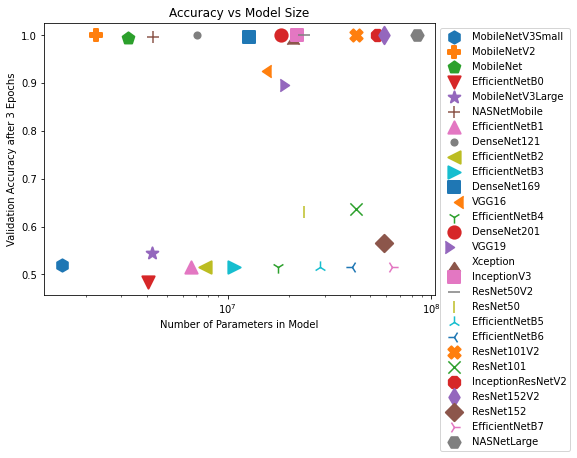

In [ ]:
# Loop over each row and plot the num_model_params vs validation_accuracy
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
plt.figure(figsize=(7,5))
for row in benchmark_df.itertuples():
    plt.scatter(row.num_model_params, row.validation_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Validation Accuracy after 3 Epochs')
plt.title('Accuracy vs Model Size')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left'); # Move legend out of the plot